# Cats vs Dogs convnet classifier from scratch

---




In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os, shutil

##Import dataset through Kaggle API

In [ ]:
#Prep directory to download dataset using Kaggle API
#  ***NOTE*** Requires manual upload of kaggle.json credentials file
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#Download data
! kaggle competitions download dogs-vs-cats

 99% 806M/812M [00:10<00:00, 104MB/s] 
100% 812M/812M [00:10<00:00, 78.2MB/s]


In [ ]:
#unzip dogs-vs-cats file
from zipfile import ZipFile
file_name = '/content/dogs-vs-cats.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
#unzip train file
from zipfile import ZipFile
file_name = '/content/train.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


##Create, organize, and populate directories with small portion of dataset

In [ ]:
original_dataset_dir = '/content/train'

#Create directories for train, validation, and test data
#Train and validation directories should each contain 2 subdirectories, one for each class

base_dir = '/content/cats_and_dogs_small'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

#Populates directories with small amount of the dataset

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_cats_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cats_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_dogs_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)

##Define network architecture and compile model

In [ ]:
#Define network structure: 4 convolutional + maxpool layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#Compile model
model.compile(loss='binary_crossrentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


##Create generators and train model

In [ ]:
#Create generators to input data into model
#How do different classes get combined?
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
#Train model
#Hardcoding steps_per_epoch can result in "Ran out of Data" error
#Avalilable data must be >= batch_size * steps_per_epoch
#in this case, 2000 images available in train = batch_size=20 * steps_per_epoch=100
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

In [ ]:
model.save('cats_and_dogs_small_1.h5')

##Plot loss and accuracy

In [ ]:
#Plot loss and accuracy
def plot_loss_acc(stats):
  acc = stats.history['acc']
  val_acc = stats.history['val_acc']
  loss = stats.history['loss']
  val_loss = stats.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()

  plt.show()

In [ ]:
plot_loss_acc(history)

#Improved Cats vs Dogs convnet


##Data augmentation example

In [ ]:
# Use generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
from tensorflow.keras.preprocessing import image

#Print images to visualize data augmentation
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break
plt.show()

##Updated model

*   Data augmentation
*   Dropout



In [ ]:
#Add dropout to architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['acc']
)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #Augmentation, doing more than just rescaling now
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size, #Good way to "avoid out of data" error
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size)

plot_loss_acc(history)

In [ ]:
model.save('cats_and_dogs_small_augmentation.h5')

# Using a pretrained convnet (VGG16)

##Feature extraction without data augmentation (fast)
Separates feature extraction from Dense network training

In [ ]:
from tensorflow.keras.applications import VGG16
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Convolutional network pretrained on 1000 image classes of everyday oblects
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_dir = '/content/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

#Pass each sample through conv_net
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

#Format feature extractions for dense network
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'],
              loss='binary_crossentropy')

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

plot_loss_acc(history)

##Feature extraction WITH data augmentation (slow)
Runs samples through both convnet and Dense network while training, resulting in slower training times but allows for data augmentation

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#Freeze layers before compilation
conv_base.trainable = False

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size)

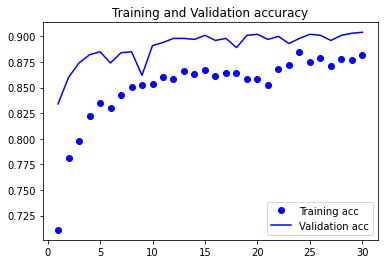

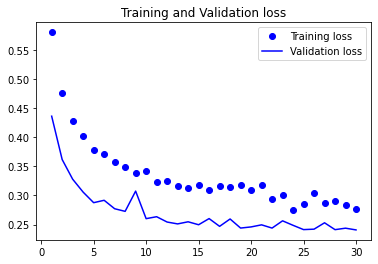

In [ ]:
plot_loss_acc(history)

##Fine-tuning the network

In [ ]:
#Make last conv block trainable for fine-tuning
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
conv_base.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n//validation_generator.batch_size)

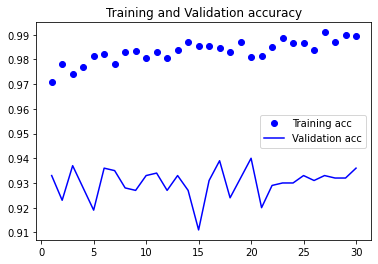

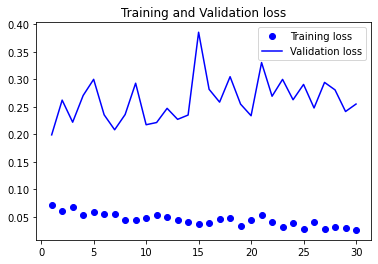

In [ ]:
plot_loss_acc(history)

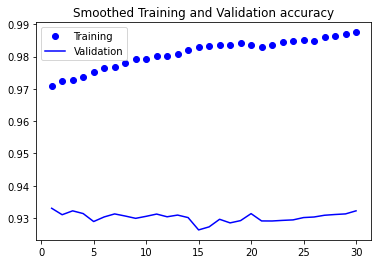

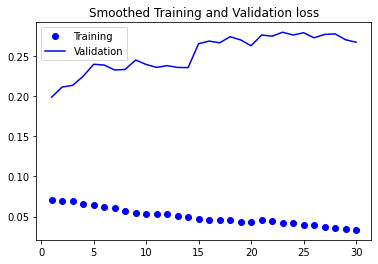

In [ ]:
#Plot is pretty noisy, use exponential moving average to smooth plot
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

acc_smooth = smooth_curve(history.history['acc'])
val_acc_smooth = smooth_curve(history.history['val_acc'])
loss_smooth = smooth_curve(history.history['loss'])
val_loss_smooth = smooth_curve(history.history['val_loss'])

epochs = range(1, len(acc_smooth) + 1)

plt.plot(epochs, acc_smooth, 'bo', label='Training')
plt.plot(epochs, val_acc_smooth, 'b', label='Validation')
plt.title('Smoothed Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss_smooth, 'bo', label='Training')
plt.plot(epochs, val_loss_smooth, 'b', label='Validation')
plt.title('Smoothed Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
#Evaluate fine-tuned network
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 4s 84ms/step - loss: 0.2698 - acc: 0.9460
test acc: 0.9459999799728394
